Retrieving USGS data for 01108000 from 2010-10-01 to 2020-01-01
41.9339903 -70.9564307
Retrieving NOAA data for GHCND:USC00190840 from 2010-10-01 to 2020-01-01
Requesting data from 2010-10-01 to 2011-09-30...
Requesting data from 2011-10-01 to 2012-09-29...
Requesting data from 2012-09-30 to 2013-09-29...
Requesting data from 2013-09-30 to 2014-09-29...
Requesting data from 2014-09-30 to 2015-09-29...
Error 503: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>503 Service Unavailable</title>
</head><body>
<h1>Service Unavailable</h1>
<p>The server is temporarily unable to service your
request due to maintenance downtime or capacity
problems. Please try again later.</p>
<p>Additionally, a 503 Service Unavailable
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>

Requesting data from 2015-09-30 to 2016-09-28...
Requesting data from 2016-09-29 to 2017-09-28...
Requesting data from 2017-09-29 to 2018-09-28...
Requesti

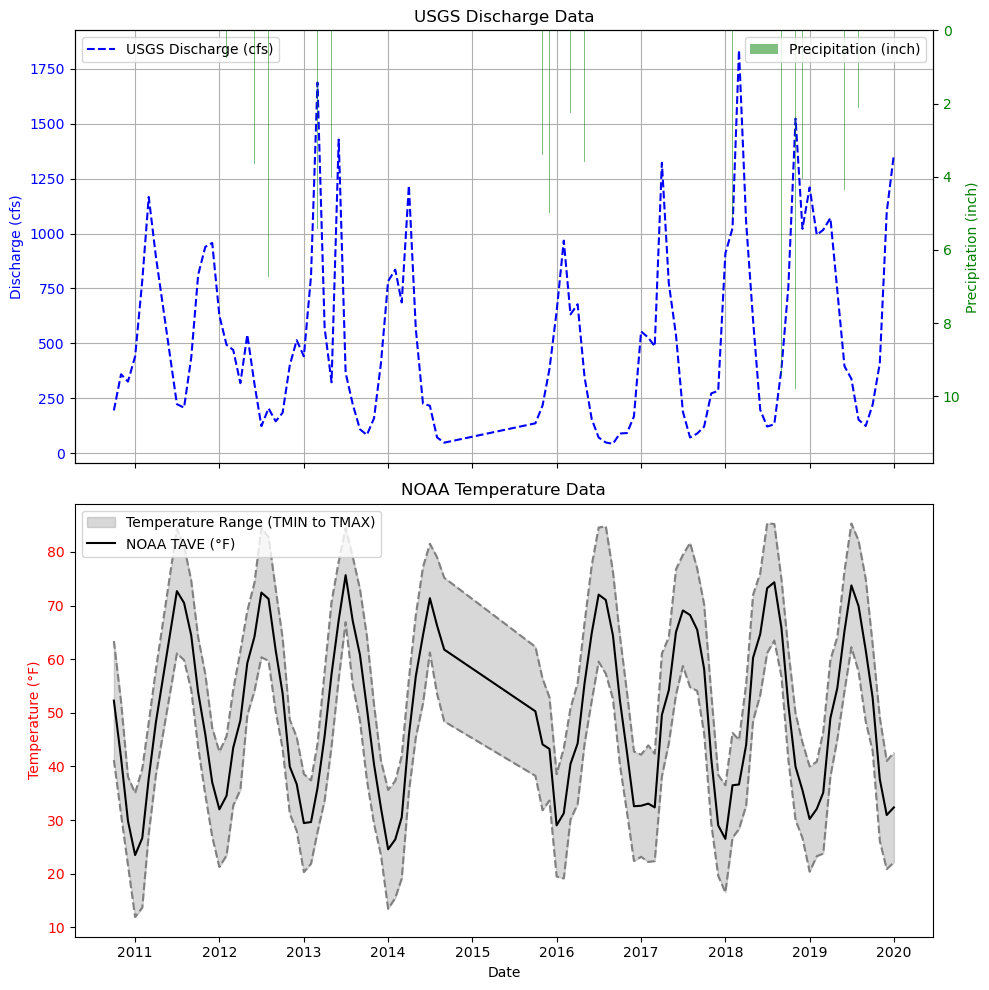

In [5]:
from dataretrieval import nwis  # For USGS data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import cos, sin, acos, pi, tan
from scipy.optimize import minimize
from datetime import datetime, timedelta


noaa_site_id= "GHCND:USC00190840"
usgs_site_id="01108000"
start_date = "2010-10-01"
end_date = "2020-01-01"
NOAA_API_TOKEN="lqbBOsoeMwxZbPbaOsZpjdSODFPAqQGG"


def grab_usgs_data(site_no, start_date, end_date):
    """
    Retrieve daily average flow data from USGS.
    :param site_no: USGS site number
    :param start_date: Start date
    :param end_date: End date
    :return: USGS DataFrame with monthly Ave
    """
    print(f"Retrieving USGS data for {site_no} from {start_date} to {end_date}")
    df = nwis.get_dv(
        sites=site_no,
        parameterCd="00060",
        statCd="00003",
        start=start_date,
        end=end_date,
    )[0].reset_index()

    site_info = nwis.get_record(site_no,service='site')
    lat=site_info.loc[0,'dec_lat_va']
    long=site_info.loc[0,'dec_long_va']
    lat_radians= lat*(pi / 180)
    print(lat,long)

    df = df.rename(columns={'datetime': 'Date'})
    df = df.rename(columns={'datetime': 'Date', '00060_Mean': 'Flow'})
    df['Date'] = df['Date'].dt.tz_convert(None)
    df = df[['Date', 'Flow']] 
    df['Flow'] = df['Flow'].astype(float) 
    df.set_index('Date', inplace=True)
    monthly_avg = df.resample('M').mean().reset_index()
    monthly_avg['Date'] = monthly_avg['Date'].apply(lambda x: x.replace(day=1))
    return monthly_avg, lat, long, lat_radians

def grab_noaa_data(site_id, start_date, end_date):
    """
    Retrieve climate data from NOAA for multiple years.
    :param site_id: NOAA site ID
    :param start_date: Start date (YYYY-MM-DD)
    :param end_date: End date (YYYY-MM-DD)
    :return: DataFrame containing monthly Precipitation and Temperature data
    """
    print(f"Retrieving NOAA data for {site_id} from {start_date} to {end_date}")
    
    NOAA_API_TOKEN = "lqbBOsoeMwxZbPbaOsZpjdSODFPAqQGG"
    url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": NOAA_API_TOKEN}
    all_data = []
    
    # Convert start_date and end_date to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Loop through each year and make requests
    current_start = start_date
    while current_start <= end_date:
        current_end = min(current_start + timedelta(days=364), end_date)  # NOAA API has a limit of 1 year per request
        
        params = {
            "datasetid": "GSOM",  # Global Historical Climatology Network - Daily
            "datatypeid": "TMAX,TMIN,PRCP",  # Request TMAX, TMIN, PRCP
            "stationid": site_id,
            "startdate": current_start.strftime("%Y-%m-%d"),
            "enddate": current_end.strftime("%Y-%m-%d"),
            "limit": 1000  # Maximum records per request
        }
        
        print(f"Requesting data from {current_start.strftime('%Y-%m-%d')} to {current_end.strftime('%Y-%m-%d')}...")
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            if "results" in data:
                all_data.extend(data["results"])
        else:
            print(f"Error {response.status_code}: {response.text}")
        
        # Move to the next year
        current_start = current_end + timedelta(days=1)
    
    # Convert the collected data into a DataFrame
    if all_data:
        df = pd.DataFrame(all_data)
        df = df[['date', 'datatype', 'value']]
        df = df.pivot(index='date', columns='datatype', values='value').reset_index()
        df.columns = ['Date', 'PRCP', 'TMAX', 'TMIN']
        df['TMAX'] = df['TMAX'].interpolate(method='linear') # change to sin interpolate at some point
        df['TMIN'] = df['TMIN'].interpolate(method='linear')
        df['PRCP'] = df['PRCP'].fillna(0)
        df['TMAX_F'] = (df['TMAX']) * 1.8 + 32  # Convert Celsius to Fahrenheit
        df['TMIN_F'] = (df['TMIN']) * 1.8 + 32  # Convert Celsius to Fahrenheit
        df['PRCP'] = df['PRCP'] * 0.03937008  # Convert precipitation to inches
        df['Date'] = pd.to_datetime(df['Date'])
        df['TAVE_F'] = (df['TMAX_F'] + df['TMIN_F']) / 2
        df['TAVE'] = (df['TMAX'] + df['TMIN']) / 2
    else:
        print("No data retrieved.")
        df = pd.DataFrame()  # Return empty DataFrame if no data
    
    return df


def merge_data(usgs_data, noaa_data):
    # Merge the USGS and NOAA data on 'Date'
    merged_df = pd.merge(usgs_data, noaa_data, on='Date', how='inner')
    merged_df['DOY'] = merged_df['Date'].dt.dayofyear
    return(merged_df)

def climate_plot(data):
    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Plot USGS discharge data on the first subplot (ax1)
    ax1.plot(data['Date'], data['Flow'], label='USGS Discharge (cfs)', color='blue', linestyle='--')
    ax1.set_ylabel('Discharge (cfs)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('USGS Discharge Data')
    ax1.grid()

    # Create a second y-axis for precipitation
    ax1_precip = ax1.twinx()
    ax1_precip.bar(data['Date'], data['PRCP'], color='green', alpha=0.5, label='Precipitation (inch)')
    ax1_precip.set_ylabel('Precipitation (inch)', color='green')
    ax1_precip.tick_params(axis='y', labelcolor='green')

    # Reverse the precipitation axis
    ax1_precip.invert_yaxis()

    # Add legends for discharge and precipitation
    ax1.legend(loc='upper left')
    ax1_precip.legend(loc='upper right')

    # Plot NOAA temperature data on the second subplot (ax2)
    ax2.plot(data['Date'], data['TMAX_F'], color='gray',linestyle='--', label='_nolegend_')
    ax2.plot(data['Date'], data['TMIN_F'], color='gray',linestyle='--', label='_nolegend_')

    # Fill the area between TMIN and TMAX
    ax2.fill_between(data['Date'], data['TMIN_F'], data['TMAX_F'], color='gray', alpha=0.3, label='Temperature Range (TMIN to TMAX)')

    # Plot TAVE on the same subplot
    ax2.plot(data['Date'], data['TAVE_F'], label='NOAA TAVE (°F)', color='black')

    ax2.set_ylabel('Temperature (°F)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_title('NOAA Temperature Data')

    # Add legends for both subplots
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    # Set the x-axis label
    ax2.set_xlabel('Date')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
  
    return 


usgs_data,lat, long, lat_radians = grab_usgs_data(usgs_site_id, start_date, end_date)
noaa_data = grab_noaa_data(noaa_site_id, start_date, end_date)


raw = merge_data(usgs_data, noaa_data)

climate_plot(raw)
#climate_plot(raw)


In [14]:
print(lat,long)

41.9339903 -70.9564307


In [7]:
abcd_model=raw.copy()
abcd_model.head()
#pd.set_option('display.max_columns', None)

#raw.to_excel(r"C:\Users\inmangm\OneDrive - CDM Smith\abcd Model\temp.xlsx")
raw.head()

nan_counts = raw.isna().sum()
print(nan_counts)

Date      0
Flow      0
PRCP      0
TMAX      0
TMIN      0
TMAX_F    0
TMIN_F    0
TAVE_F    0
TAVE      0
DOY       0
dtype: int64


Original RMSE: 260.24081819625025
Optimization successful.
Optimized parameters: [ 0.96499465 20.40481035  0.1         0.31584949 50.        ]
Minimum RMSE: 204.05567055461864


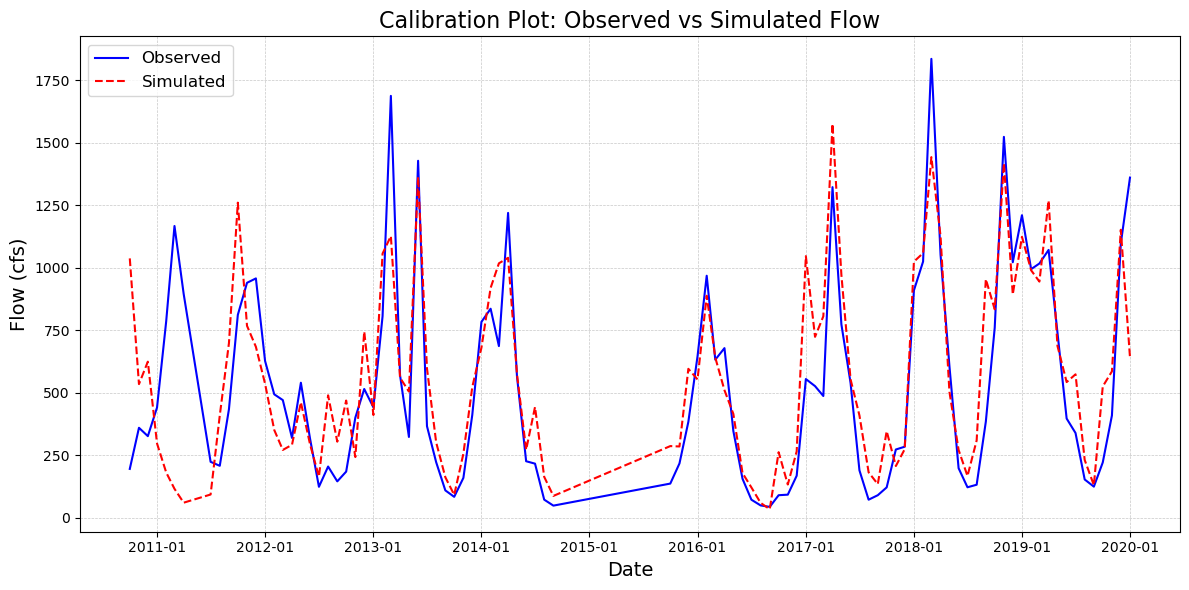

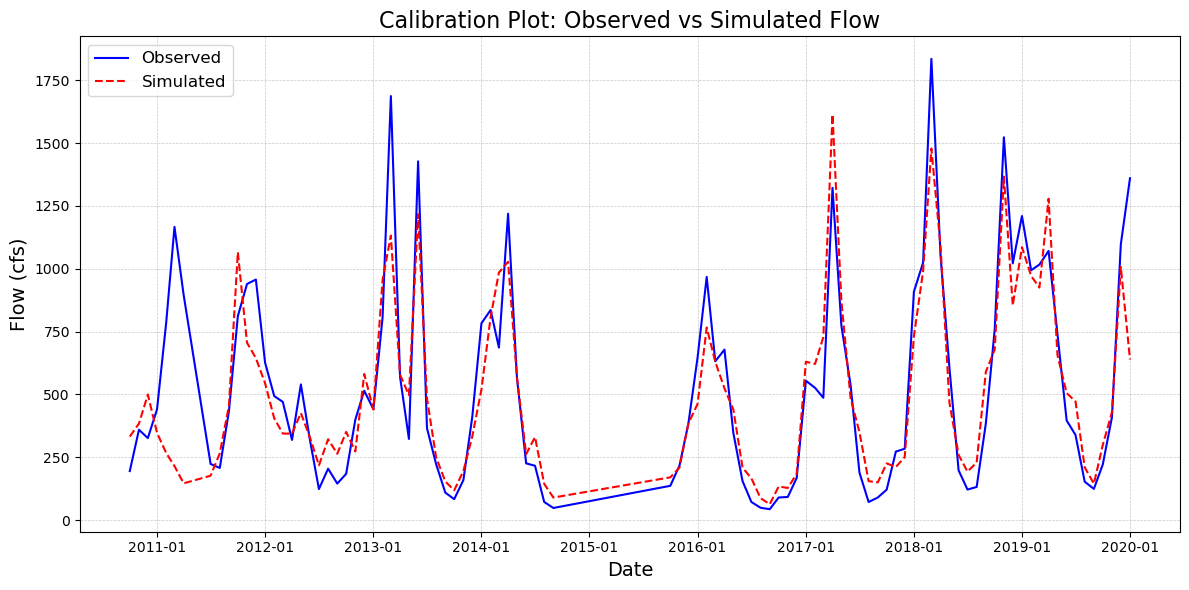

In [8]:

def model(data, a, b, c, d, e, Tb, lat, S_init, G_init, Area):
    data=data.dropna()
    Tave = data['TAVE']
    Tmax = data['TMAX']
    Tmin = data['TMIN']
    Precip = data['PRCP']
    

    # Day Length Factor (dr)
    data['dr'] = 1 + 0.033 * np.cos(2 * np.pi * data['DOY'] / 365)

    # Solar Declination Angle (del)
    data['del'] = 0.4093 * np.sin((2 * np.pi * data['DOY'] / 365) - 1.405)

    # Solar Hour Angle (ws) in radians
    data['ws'] = np.arccos(-1 * np.tan(data['del']) * np.tan(lat))

    # Hours of sunshine (hrs)
    data['hrs'] = 24 / np.pi * data['ws']

    # Solar Radiation (Sol, in mm/day)
    data['Sol'] = 15.392 * data['dr'] * (
        data['ws'] * np.sin(lat) * np.sin(data['del']) +
        np.cos(lat) * np.cos(data['del']) * np.sin(data['ws'])
    )

    # Potential Evapotranspiration (PEt, in mm/day)
    data['PEt'] = 0.0023 * data['Sol'] * (Tave + 17.8) * np.sqrt(Tmax - Tmin)

    # Actual Evapotranspiration (PE, converted to inches per month)
    data['PE'] = (np.where(Tmin < Tb, 0, data['PEt'] / 25.4)) * 30.4

    # Initialize arrays for snow accumulation, snow melt, available water, evapotranspiration opportunity,
    # soil moisture, and groundwater storage
    Snow_acc = np.zeros(len(Tave))
    Snow_melt = np.zeros(len(Tave))
    W = np.zeros(len(Tave))
    Y = np.zeros(len(Tave))
    S = np.zeros(len(Tave))
    GW = np.zeros(len(Tave))
    
    # Loop through each time step
    for t in range(len(Tave)):
        # Snow model calculations (as implemented before)
        if t == 0:
            Snow_acc[t] = 0
            Snow_melt[t] = min(Snow_acc[t], e * abs(Tave[t] - Tb)) if Tave[t] > Tb else 0
            W[t] = Precip[t] + S_init
            GW[t] = G_init
        elif t < len(Tave) - 1:
            Snow_acc[t] = (Snow_acc[t - 1] + Precip.iloc[t + 1] - Snow_melt[t - 1] 
                           if Tave.iloc[t + 1] < Tb 
                           else Snow_acc[t - 1] - Snow_melt[t - 1])
            Snow_melt[t] = min(Snow_acc[t], e * abs(Tave[t] - Tb)) if Tave[t] > Tb else 0
            W[t] = Precip[t] + S[t - 1]
        else:
            Snow_acc[t] = Snow_acc[t - 1] - Snow_melt[t - 1]
            Snow_melt[t] = min(Snow_acc[t], e * abs(Tave[t] - Tb)) if Tave[t] > Tb else 0
            W[t] = Precip[t] + S[t - 1]

        # Calculate intermediate values w1 and w2
        w1 = (W[t] + b) / (2 * a)
        w2 = W[t] * b / a

        # Calculate Y (evapotranspiration opportunity)
        Y[t] = w1 - np.sqrt((w1 ** 2) - w2)

        # Calculate S (soil moisture)
        S[t] = Y[t] * np.exp(-1 * data['PE'].iloc[t] / b)

        # Calculate GW (groundwater storage)
        if t > 0:
            GW[t] = (c * (W[t] - Y[t]) + GW[t - 1]) / (1 + d)

    # Add calculated columns to the DataFrame
    data['W'] = W
    data['Y'] = Y
    data['S'] = S
    data['GW'] = GW

    # Runoff and Baseflow calculations
    data['Runoff'] = ((1 - c) * (W - Y)) / 12 * Area * 43560 * 7.48 / 1000000  # MG
    data['Baseflow'] = (GW * d) / 12 * Area * 43560 * 7.48 / 1000000  # MG
    data['SimFlow_MG'] = data['Runoff'] + data['Baseflow']
    data['SimFlow_CFS'] = data['SimFlow_MG'] / 0.646 / 30.4  # CFS
    return data


def calibration(data, a, b, c, d, e, Tb, lat, S_init, G_init, Area):
    # Define the objective function to minimize (RMSE)
    def objective(params):
        a, b, c, d, e = params
        model_result = model(data, a, b, c, d, e, Tb, lat, S_init, G_init, Area)
        obs = model_result["Flow"]
        sim = model_result["SimFlow_CFS"]
        rmse = np.sqrt(np.mean((obs - sim) ** 2))
        return rmse

    # Calculate original RMSE before minimizing
    model_result = model(data, a, b, c, d, e, Tb, lat, S_init, G_init, Area)
    obs = model_result["Flow"]
    sim = model_result["SimFlow_CFS"]
    original_rmse = np.sqrt(np.mean((obs - sim) ** 2))
    print("Original RMSE:", original_rmse)


    # Initial guess for the parameters
    initial_guess = [a, b, c, d, e]

    # Define the bounds for each parameter
    bounds = [
        (1e-6, 1),        # a_lims
        (10, 50),      # b_lims
        (0.10, 0.90),  # c_lims
        (0.1, 0.90),   # d_lims
        (0, 75)        # e_lims
    ]

    # Perform the optimization to minimize RMSE
    result = minimize(objective, initial_guess, bounds=bounds)

    # Check if the optimization was successful
    if result.success:
        optimized_params = result.x
        print("Optimization successful.")
        print("Optimized parameters:", optimized_params)
        print("Minimum RMSE:", result.fun)
    else:
        print("Optimization failed.")
        optimized_params = None

    return optimized_params

def calibration_plot(data):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actual discharge data
    ax.plot(data['Date'], data['Flow'], label='Observed', color='blue', linewidth=1.5)

    # Plot simulated flow data
    ax.plot(data['Date'], data['SimFlow_CFS'], label='Simulated', color='red', linestyle='--', linewidth=1.5)

    # Set plot title and labels
    ax.set_title('Calibration Plot: Observed vs Simulated Flow', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Flow (cfs)', fontsize=14)

    # Format the x-axis for better readability

    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add legend to differentiate between observed and simulated data
    ax.legend(loc='upper left', fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

a = 0.984560007283129
b = 5.05578448178507
c = 0.710407747560437
d = 0.9
e = 50
Tb = -4.8144232589882
G_init = 2
S_init = 10
lat=lat_radians
Area = 167040 # Acres

df2 = model(abcd_model, a, b, c, d, e, Tb, lat, S_init, G_init, Area)
calibration_plot(df2)
[a,b,c,d,e]=calibration(df2, a, b, c, d, e, Tb, lat, S_init, G_init, Area)
df3=model(df2, a, b, c, d, e, Tb, lat, S_init, G_init, Area)
calibration_plot(df3)
#df2.head()


In [ ]:
lat=41.9339903
long= -70.9564307

In [2]:
import cdsapi
    
client = cdsapi.Client()

dataset = 'reanalysis-era5-pressure-levels'
request = {
    'product_type': ['reanalysis'],
    'variable': ['geopotential'],
    'year': ['2024'],
    'month': ['03'],
    'day': ['01'],
    'time': ['13:00'],
    'pressure_level': ['1000'],
    'data_format': 'grib',
}
target = 'download.grib'

client.retrieve(dataset, request, target)

2024-11-28 14:23:06,501 WARNING [2024-11-27T00:00:00] System is back on service under testing conditions. Please follow updates [here](https://forum.ecmwf.int/t/cds-ads-and-ewds-down-until-further-notice/8015) and status [here](https://status.ecmwf.int/)
2024-11-28 14:23:06,502 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-28 14:23:06,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-28 14:23:06,503 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-

HTTPError: 403 Client Error: Forbidden for url: https://cds.climate.copernicus.eu/api/retrieve/v1/processes/reanalysis-era5-pressure-levels/execution
required licences not accepted
Not all the required licences have been accepted; please visit https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=download#manage-licences to accept the required licence(s).